In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import rampy as rp
import pandas as pd

import sklearn
from sklearn.externals import joblib

import neuravi
import sys
sys.path.append("/home/charles/GoogleDrive/viscopy/")
import viscopy as vp

# Loading dataset

Dataset has been prepared before

In [2]:
d = neuravi.Data("./data/")

# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = d.X_train[:,0:4] # 14 for all dataset, 4 for KNAS
cp_train = d.X_train[:,(4,5)]
temperature_train = d.X_train[:,6].reshape(-1,1)

chimie_valid = d.X_valid[:,0:4]
cp_valid = d.X_valid[:,(4,5)]
temperature_valid = d.X_valid[:,6].reshape(-1,1)

chimie_test = d.X_test[:,0:4]
cp_test = d.X_test[:,(4,5)]
temperature_test = d.X_test[:,6].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

In [8]:
name_in = "KNAS_AG_noCp_layer_1units_100it_10000"

figure_name = "KNAS_AG.pdf"

In [9]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('ap:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('b:0')
        
        # Get prediction tensor
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        
        # make predictions
        train_n, train_ap, train_b = sess.run((pred, cp_a_placeholder, cp_b_placeholder), 
                                              feed_dict={chimie_placeholder: chimie_train,
                                                     T_placeholder: temperature_train})
        
        valid_n, valid_ap, valid_b = sess.run((pred, cp_a_placeholder, cp_b_placeholder), 
                                              feed_dict={chimie_placeholder: chimie_valid,
                                                     T_placeholder: temperature_valid})
        
        test_n, test_ap, test_b  = sess.run((pred, cp_a_placeholder, cp_b_placeholder), 
                                            feed_dict={chimie_placeholder: chimie_test,
                                                     T_placeholder: temperature_test})
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/KNAS_AG_noCp_layer_1units_100it_10000/variables/variables
Ok
Predictions done


In [10]:
print("RMSE %.2f" %mean_squared_error(d.y_train, train_n))

RMSE 0.32


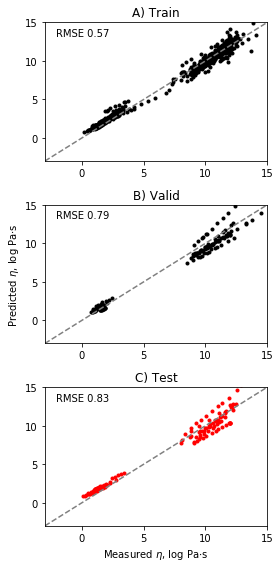

In [12]:
plt.figure(figsize=(4,8))
plt.subplot(3,1,1)
plt.title("A) Train")
plt.plot(d.y_train, train_n,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_train, train_n)),xy=(0.05,0.9),xycoords="axes fraction")

plt.subplot(3,1,2)
plt.title("B) Valid")
plt.plot(d.y_valid, valid_n,"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_valid, valid_n)),xy=(0.05,0.9),xycoords="axes fraction")

plt.ylabel("Predicted $\eta$, log Pa$\cdot$s")

plt.subplot(3,1,3)
plt.title("C) Test")
plt.plot(d.y_test, test_n,"r.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.annotate("RMSE %.2f" % np.sqrt(mean_squared_error(d.y_test, test_n)),xy=(0.05,0.9),xycoords="axes fraction")

plt.xlabel("Measured $\eta$, log Pa$\cdot$s")

plt.tight_layout()

plt.savefig(figure_name)

# Quantification of RMSE

In [13]:
MSE_NN_train = np.sqrt(mean_squared_error(d.y_train, train_n))
MSE_NN_valid = np.sqrt(mean_squared_error(d.y_valid, valid_n))
MSE_NN_test = np.sqrt(mean_squared_error(d.y_test, test_n))

print("training, validation and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)
print(MSE_NN_test)

training, validation and testing RMSE with neural nets
0.5658640920206773
0.7880479265503754
0.8327766988520402


# Calculating Ae

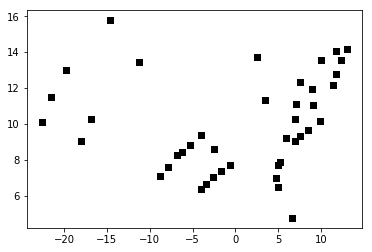

In [17]:
plt.plot(cp_train[:,0], train_ap,"ks")

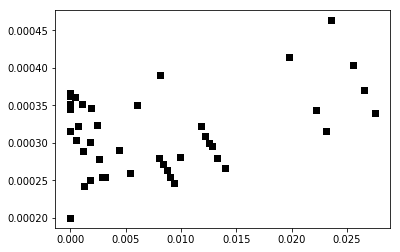

In [18]:
plt.plot(cp_train[:,1], train_b,"ks")

In [18]:
# KNAS, comment to deactivate
dataset = pd.read_excel("../viscopy/development/data/Database.xlsx",sheet_name="knas")
dataset.head()

dataset = vp.chimie_control(dataset)
ap, b = vp.heatcp(dataset,dataset.tg)

dataset['ap'] = ap
dataset['b'] = b
dataset.head()

,sio2,al2o3,fe2o3,li2o,na2o,k2o,mgo,cao,feo,tg,...,ref,color,tio2,h2o,bao,nio,mno,p2o5,ap,b
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,U1982,black,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,U1982,black,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,U1982,black,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,U1982,black,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0,...,U1982,black,0.0,0.0,0.0,0.0,0.0,0.0,6.544,0.0


# TECTOSILICATES


Restoring...
INFO:tensorflow:Restoring parameters from model/KNAS_AG_layer_1units_200it_10000/variables/variables
Ok
Predictions done


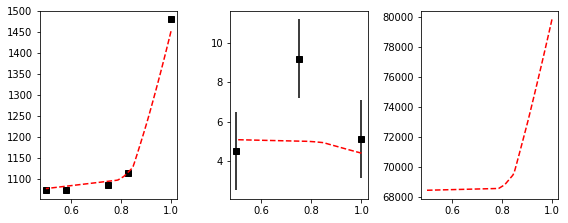

In [19]:
# only tectosilicate
na2otecto_subset = dataset[dataset.loc[:,"al2o3"] == dataset.loc[:,"na2o"]+dataset.loc[:,"k2o"]]
na2otecto_subset = na2otecto_subset[na2otecto_subset.loc[:,"k2o"]==0.0]
na2otecto_subset = na2otecto_subset.drop_duplicates(["tg"])
na2otecto_subset

#natecto_chimie = na2otecto_subset.loc["sio2","al2o3","na2o","k2o"]
#natecto_chimie = na2otecto_subset.loc["sio2","al2o3","na2o","k2o"]

natecto_forplot = pd.DataFrame()

natecto_forplot["sio2"] = np.linspace(1.0,0.5,100)
natecto_forplot["al2o3"] = np.linspace(0.0,0.25,100)
natecto_forplot["na2o"]  = np.linspace(0.0,0.25,100)
natecto_forplot["k2o"] = np.zeros(100)
natecto_forplot["mgo"] = np.zeros(100)
natecto_forplot["cao"] = np.zeros(100)
natecto_forplot["t"] = 1000.0*np.ones(100)

ap, b = vp.heatcp(natecto_forplot,1.0)

natecto_forplot["ap"] = ap
natecto_forplot["b"] = b

natecto_chimie = natecto_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
natecto_cp = natecto_forplot.loc[:,["ap","b"]].values
natecto_t = natecto_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), feed_dict={chimie_placeholder: natecto_chimie,
                                                   cp_a_placeholder: natecto_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: natecto_cp[:,1].reshape(-1,1),
                                                     T_placeholder: natecto_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(na2otecto_subset.sio2,na2otecto_subset.tg,"ks")
plt.plot(natecto_forplot["sio2"],Tg_tecto_pred,"r--")

plt.subplot(1,3,2)
plt.plot(natecto_forplot["sio2"],S_tecto_pred,"r--")
plt.errorbar([1.,0.75,0.5],[5.1,9.2,4.5],yerr=[2.,2.,2.],fmt="s",color="k")

plt.subplot(1,3,3)
plt.plot(natecto_forplot["sio2"],Be_tecto_pred,"r--")

plt.tight_layout()

# SILICATES


Restoring...
INFO:tensorflow:Restoring parameters from model/KNAS_AG_layer_1units_200it_10000/variables/variables
Ok
Predictions done


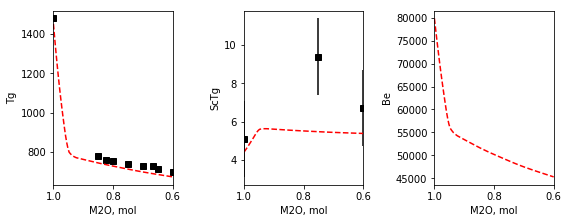

In [20]:
# only tectosilicate
nasilicates_subset = dataset[(dataset.loc[:,"al2o3"] == 0.0)&(dataset.loc[:,"k2o"] == 0.0)]
#nasilicates_subset = nasilicates_subset[nasilicates_subset.loc[:,"k2o"] == 0.0]
nasilicates_subset = nasilicates_subset.drop_duplicates(["tg"])

nasilicates_forplot = pd.DataFrame()

nasilicates_forplot["sio2"] = np.linspace(1.0,0.6,100)
nasilicates_forplot["al2o3"] = np.zeros(100)
nasilicates_forplot["na2o"]  = np.linspace(0.0,0.6,100)
nasilicates_forplot["k2o"] = np.zeros(100)
nasilicates_forplot["mgo"] = np.zeros(100)
nasilicates_forplot["cao"] = np.zeros(100)
nasilicates_forplot["t"] = 1000.0*np.ones(100)

ap, b = vp.heatcp(nasilicates_forplot,1.0)

nasilicates_forplot["ap"] = ap
nasilicates_forplot["b"] = b

nasilli_chimie = nasilicates_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nasilli_cp = nasilicates_forplot.loc[:,["ap","b"]].values
nasilli_t = nasilicates_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: nasilli_chimie,
                                                   cp_a_placeholder: nasilli_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nasilli_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nasilli_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nasilicates_subset.sio2,nasilicates_subset.tg,"ks")
plt.plot(nasilicates_forplot["sio2"],Tg_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nasilicates_forplot["sio2"],S_tecto_pred,"r--")
plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nasilicates_forplot["sio2"],Be_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

# Na-K mixing

      sio2  al2o3  fe2o3  li2o   na2o    k2o  mgo  cao  feo     tg    ...     \
79   0.750    0.0    0.0   0.0  0.250  0.000  0.0  0.0  0.0  737.0    ...      
232  0.750    0.0    0.0   0.0  0.000  0.250  0.0  0.0  0.0  750.0    ...      
291  0.758    0.0    0.0   0.0  0.129  0.113  0.0  0.0  0.0  705.0    ...      
297  0.768    0.0    0.0   0.0  0.066  0.166  0.0  0.0  0.0  721.0    ...      

      ref   color tio2  h2o  bao  nio  mno  p2o5         ap         b  
79   TODO    blue  0.0  0.0  0.0  0.0  0.0   0.0  11.351500  0.000000  
232  TODO  purple  0.0  0.0  0.0  0.0  0.0   0.0   5.844938  0.003945  
291  TODO     red  0.0  0.0  0.0  0.0  0.0   0.0   6.962839  0.001783  
297  TODO     red  0.0  0.0  0.0  0.0  0.0   0.0   5.837768  0.002619  

[4 rows x 22 columns]

Restoring...
INFO:tensorflow:Restoring parameters from model/KNAS_AG_layer_1units_200it_10000/variables/variables
Ok
Predictions done


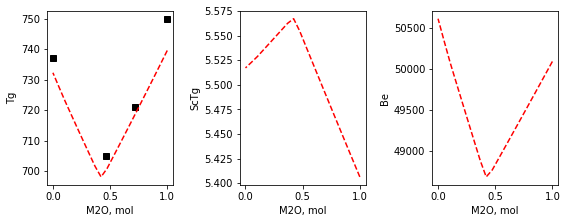

In [21]:
nak_subset = dataset.loc[(dataset.loc[:,"sio2"] > 0.73)&
                         (dataset.loc[:,"sio2"] < 0.77)&
                         (dataset.loc[:,"al2o3"]==0.00) 
                         #(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.75*np.ones(20)
nak_forplot["al2o3"] = 0.0*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.25,20)
nak_forplot["k2o"] = 0.25-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = nak_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks")
         
         
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--")
#plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

      sio2  al2o3  fe2o3  li2o   na2o    k2o  mgo  cao  feo     tg    ...     \
120  0.667    0.0    0.0   0.0  0.333  0.000  0.0  0.0  0.0  726.0    ...      
263  0.660    0.0    0.0   0.0  0.000  0.340  0.0  0.0  0.0  721.0    ...      
321  0.661    0.0    0.0   0.0  0.311  0.028  0.0  0.0  0.0  680.0    ...      
327  0.672    0.0    0.0   0.0  0.263  0.065  0.0  0.0  0.0  664.0    ...      
333  0.668    0.0    0.0   0.0  0.178  0.154  0.0  0.0  0.0  665.0    ...      

      ref   color tio2  h2o  bao  nio  mno  p2o5         ap         b  
120  TODO    blue  0.0  0.0  0.0  0.0  0.0   0.0  12.947590  0.000000  
263  TODO  purple  0.0  0.0  0.0  0.0  0.0   0.0   7.496503  0.005365  
321  TODO     red  0.0  0.0  0.0  0.0  0.0   0.0  11.728425  0.000442  
327  TODO     red  0.0  0.0  0.0  0.0  0.0   0.0  10.001597  0.001026  
333  TODO     red  0.0  0.0  0.0  0.0  0.0   0.0   7.559255  0.002430  

[5 rows x 22 columns]

Restoring...
INFO:tensorflow:Restoring parameters from model/KN

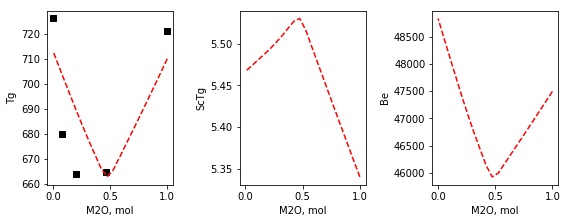

In [23]:
nak_subset = dataset.loc[(dataset.loc[:,"sio2"] > 0.65)&
                         (dataset.loc[:,"sio2"] < 0.69)&
                         (dataset.loc[:,"al2o3"]==0.00) 
                         #(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.666*np.ones(20)
nak_forplot["al2o3"] = 0.0*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.333,20)
nak_forplot["k2o"] = 0.333-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = nak_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks")
         
         
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--")
#plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

       sio2   al2o3  fe2o3  li2o    na2o     k2o  mgo  cao  feo      tg  \
392  0.7500  0.1250    0.0   0.0  0.1250  0.0000  0.0  0.0  0.0  1085.7   
434  0.7537  0.1251    0.0   0.0  0.0975  0.0237  0.0  0.0  0.0  1087.5   
453  0.7533  0.1244    0.0   0.0  0.0744  0.0479  0.0  0.0  0.0  1118.8   
470  0.7516  0.1250    0.0   0.0  0.0619  0.0615  0.0  0.0  0.0  1103.6   
487  0.7553  0.1230    0.0   0.0  0.0501  0.0715  0.0  0.0  0.0  1144.4   
501  0.7515  0.1243    0.0   0.0  0.0266  0.0976  0.0  0.0  0.0  1179.8   
514  0.7506  0.1275    0.0   0.0  0.0009  0.1210  0.0  0.0  0.0  1222.9   

       ...        ref    color tio2  h2o  bao  nio  mno  p2o5        ap  \
392    ...     LL2013  magenta  0.0  0.0  0.0  0.0  0.0   0.0 -4.057750   
434    ...     LL2013  magenta  0.0  0.0  0.0  0.0  0.0   0.0 -5.273146   
453    ...     LL2013  magenta  0.0  0.0  0.0  0.0  0.0   0.0 -6.202562   
470    ...     LL2013  magenta  0.0  0.0  0.0  0.0  0.0   0.0 -6.761179   
487    ...     LL2013  m

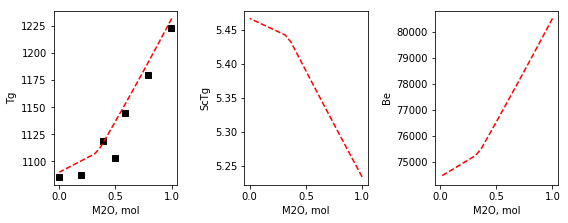

In [12]:
nak_subset = dataset.loc[#(dataset.loc[:,"sio2"] > 0.73)&
                         #(dataset.loc[:,"sio2"] < 0.77)&
                         #(dataset.loc[:,"al2o3"]==0.00) 
                         (dataset.loc[:,"sio2"] > 0.73)&
                         (dataset.loc[:,"sio2"] < 0.77)&
                         (dataset.loc[:,"al2o3"]>0.11)
                         ,:].drop_duplicates(["tg"])
#nak_subset = nak_subset.loc[nak_subset.loc[:,"al2o3"] == nak_subset.loc[:,"na2o"]+nak_subset.loc[:,"k2o"]]
print(nak_subset)

nak_forplot = pd.DataFrame()

nak_forplot["sio2"] = 0.75*np.ones(20)
nak_forplot["al2o3"] = 0.125*np.ones(20)
nak_forplot["na2o"]  = np.linspace(0.0,0.125,20)
nak_forplot["k2o"] = 0.125-nak_forplot["na2o"]
nak_forplot["mgo"] = np.zeros(20)
nak_forplot["cao"] = np.zeros(20)
nak_forplot["t"] = 1000.0*np.ones(20)


ap, b = vp.heatcp(nak_forplot,1.0)

nak_forplot["ap"] = ap
nak_forplot["b"] = b

nak_chimie = nak_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nak_cp = nak_forplot.loc[:,["ap","b"]].values
nak_t = nak_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_pred, Tg_pred, S_pred, Be_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: 
                                                                                       nak_chimie,
                                                   cp_a_placeholder: nak_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nak_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nak_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nak_subset.k2o/(nak_subset.k2o+nak_subset.na2o),nak_subset.tg,"ks")
         
         
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Tg_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),S_pred,"r--")
#plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nak_forplot["k2o"]/(nak_forplot["k2o"]+nak_forplot["na2o"]),Be_pred,"r--")
#plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

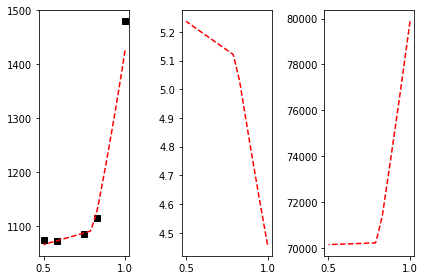

In [38]:




ap, b = vp.heatcp(nasilicates_forplot,1.0)

nasilicates_forplot["ap"] = ap
nasilicates_forplot["b"] = b

nasilli_chimie = nasilicates_forplot.loc[:,["sio2","al2o3","na2o","k2o"]].values
nasilli_cp = nasilicates_forplot.loc[:,["ap","b"]].values
nasilli_t = nasilicates_forplot.loc[:,["t"]].values.reshape(-1,1)

# GETTING THE VALUES
restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        cp_a_placeholder = restored_graph.get_tensor_by_name('cp_a:0')
        cp_b_placeholder = restored_graph.get_tensor_by_name('cp_b:0')
        
        # Get prediction tensor
        pred_n = restored_graph.get_tensor_by_name('visco_pred:0')
        pred_Tg = restored_graph.get_tensor_by_name('Tg:0')
        pred_S = restored_graph.get_tensor_by_name('entropy_Tg:0')
        pred_Be = restored_graph.get_tensor_by_name('Be:0')
        # make predictions
        n_tecto_pred, Tg_tecto_pred, S_tecto_pred, Be_tecto_pred = sess.run((pred_n,pred_Tg,pred_S, pred_Be), 
                                                                            feed_dict={chimie_placeholder: nasilli_chimie,
                                                   cp_a_placeholder: nasilli_cp[:,0].reshape(-1,1),
                                                   cp_b_placeholder: nasilli_cp[:,1].reshape(-1,1),
                                                     T_placeholder: nasilli_t})
        
        print('Predictions done')
       
# FIGURE
plt.figure(figsize=(8,3.2))
plt.subplot(1,3,1)

plt.plot(nasilicates_subset.sio2,nasilicates_subset.tg,"ks")
plt.plot(nasilicates_forplot["sio2"],Tg_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Tg")

plt.subplot(1,3,2)
plt.plot(nasilicates_forplot["sio2"],S_tecto_pred,"r--")
plt.errorbar([1.,0.75,0.6],[5.1,9.40,6.72],yerr=[2.,2.,2.],fmt="s",color="k")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("ScTg")

plt.subplot(1,3,3)
plt.plot(nasilicates_forplot["sio2"],Be_tecto_pred,"r--")
plt.xlim(1,0.6)

plt.xlabel("M2O, mol")
plt.ylabel("Be")

plt.tight_layout()

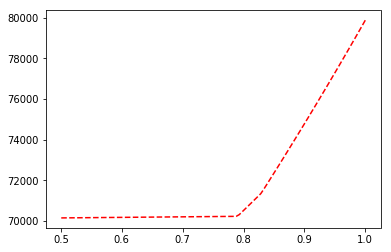

In [36]:
#plt.plot(na2otecto_subset.sio2,na2otecto_subset.tg,"ks")


In [64]:
import pandas as pd
#
dataset_post = pd.read_csv("./data/rhyolite_for_post_analysis.csv")

to_pred_c= dataset_post.loc[:,"sio2":"h2o"].values
to_pred_c = to_pred_c/to_pred_c.sum(axis=1).reshape(-1,1)
print("Chemistry array loaded:")
print(to_pred_c)

to_pred_T= dataset_post.loc[:,"T"]
print("Temperature DataFrame loaded:")
print(to_pred_T.head())

to_pred_n= dataset_post.loc[:,"viscosity"]
print("Viscosity DataFrame loaded:")
print(to_pred_n.head())

Chemistry array loaded:
[[0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         0.085      0.
  0.         0.        ]
 [0.83       0.         0.085      0.         0.         0.
  0.         0.         0.         0.         

In [65]:
from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        
        # Get prediction tensors
        pred = restored_graph.get_tensor_by_name('visco_pred:0')
        a_ = restored_graph.get_tensor_by_name('A:0')
        b_ = restored_graph.get_tensor_by_name('B:0')
        t1_ = restored_graph.get_tensor_by_name('T1:0')
        
        # make predictions
        visco_p,a_p,b_p,t1_p  = sess.run([pred,a_,b_,t1_], 
                                          feed_dict={chimie_placeholder: to_pred_c, 
                                                     T_placeholder: to_pred_T.values.reshape(-1,1)})
        
        print('Predictions done')


Restoring...
INFO:tensorflow:Restoring parameters from model/TVF_layer_1units_100it_100/variables/variables
Ok
Predictions done


In [66]:
dataset_post

,Name,sio2,tio2,al2o3,feot,mno,bao,sro,mgo,cao,li2o,na2o,k2o,p2o5,h2o,T,viscosity,ScTg,Tg,Source
0,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1112.4,12.05,Le Losq and Neuville 2013,NaN,NaN
1,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1132.8,11.61,Le Losq and Neuville 2013,NaN,NaN
2,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1148.4,11.31,Le Losq and Neuville 2013,NaN,NaN
3,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1170.5,10.98,Le Losq and Neuville 2013,NaN,NaN
4,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1185.0,10.65,Le Losq and Neuville 2013,NaN,NaN
5,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1190.3,10.58,Le Losq and Neuville 2013,NaN,NaN
6,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1201.7,10.38,Le Losq and Neuville 2013,NaN,NaN
7,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1209.5,10.22,Le Losq and Neuville 2013,NaN,NaN
8,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1211.5,10.21,Le Losq and Neuville 2013,NaN,NaN
9,NAK83 8 0,83.0,0.0,8.5,0.0,0,0,0,0.0,0.0,0,8.5,0.0,0,0.0,1227.4,9.91,Le Losq and Neuville 2013,NaN,NaN


ValueError: x and y must be the same size

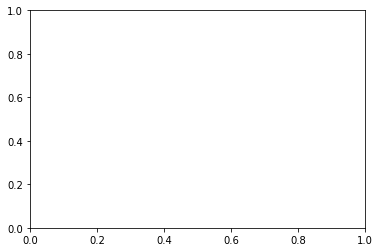

In [67]:
plt.scatter(to_pred_n,visco_p[0],c=dataset_post.k2o)
plt.colorbar()
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Viscosity")
print(np.sqrt(mean_squared_error(visco_p[0], to_pred_n)))

In [48]:
visco_p

[array([[11.837589 ],
        [11.428139 ],
        [11.127399 ],
        [10.718559 ],
        [10.460672 ],
        [10.368368 ],
        [10.173265 ],
        [10.04241  ],
        [10.009193 ],
        [ 9.749905 ],
        [ 9.756327 ],
        [ 9.261556 ],
        [ 9.362604 ],
        [ 9.689213 ],
        [ 9.931807 ],
        [10.240166 ],
        [10.455952 ],
        [10.746614 ],
        [11.1217785],
        [11.466278 ],
        [11.744598 ],
        [ 9.761924 ],
        [ 9.931669 ],
        [10.1511965],
        [10.271924 ],
        [10.515288 ],
        [10.5727625],
        [10.935584 ],
        [11.224608 ],
        [11.3817625],
        [11.713056 ],
        [11.860425 ],
        [12.188645 ],
        [10.307516 ],
        [10.472628 ],
        [10.600956 ],
        [10.80192  ],
        [11.004    ],
        [11.281811 ],
        [11.624159 ],
        [10.854235 ],
        [10.989639 ],
        [11.057198 ],
        [11.117491 ],
        [11.191982 ],
        [1

Text(0.5,1,'Measured vs Predicted Entropy')

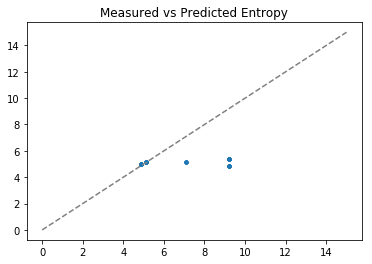

In [19]:
plt.plot(dataset_post.loc[:,"ScTg"],sctg_p,".")
plt.plot([0,15],[0,15],"--",color="grey")
plt.title("Measured vs Predicted Entropy")

Text(0.5,1,'Measured vs Predicted Glass Transition Temperature')

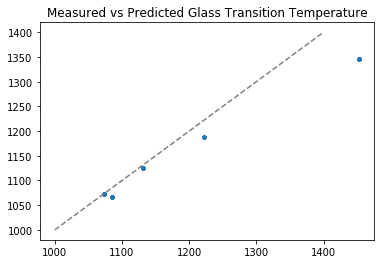

In [20]:
plt.plot(dataset_post.loc[:,"Tg"],tg_p,".")
plt.plot([1000,1400],[1000,1400],"--",color="grey")
plt.title("Measured vs Predicted Glass Transition Temperature")

# Continue Training

In [35]:
NEPOCH = 1000
loss_train = np.zeros(NEPOCH)
loss_valid = np.zeros(NEPOCH)

from tensorflow.python.saved_model import tag_constants

restored_graph = tf.Graph()
with restored_graph.as_default():
    with tf.Session(graph=restored_graph) as sess:
        # Restore saved values
        print('\nRestoring...')
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            "model/"+name_in
        )
        print('Ok')
        
        # Get restored placeholders
        T_placeholder = restored_graph.get_tensor_by_name('T:0')
        chimie_placeholder = restored_graph.get_tensor_by_name('chimie:0')
        n_placeholder = restored_graph.get_tensor_by_name('viscosity:0')
        
        # Get loss
        opt = restored_graph.get_collection('optimizer')
        loss = restored_graph.get_tensor_by_name('loss:0')
        
        for i in range(NEPOCH):
        
            # train
            sess.run(opt,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            # calculate loss
            loss_train[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_train, 
                                 T_placeholder: temperature_train.reshape(-1,1),
                                 n_placeholder: d.y_train.reshape(-1,1)})
            loss_valid[i] = sess.run(loss,feed_dict={chimie_placeholder: chimie_valid, 
                                 T_placeholder: temperature_valid.reshape(-1,1),
                                 n_placeholder: d.y_valid.reshape(-1,1)})
        
            if (i % 500 == 0):
                print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
        print('Training done')


Restoring...
INFO:tensorflow:Restoring parameters from model/layer1units200it10000/variables/variables
Ok


ValueError: could not convert string to float: b'\n\x0b\n\x04loss\x15\xa5%TD'

In [ ]:
tf.nn.l2_loss()